In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


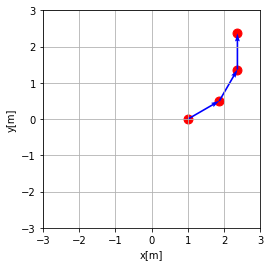

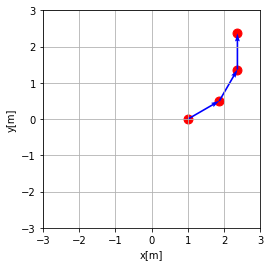

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.5 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

X_train = []
'''
for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    if(len(d) > 10):
        print(rand_rad)
        print(d)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.5
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.05
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


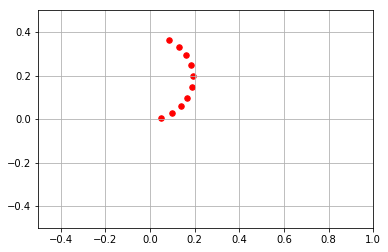

 -- x_train -- 
[[ 0.05044695  0.00677326 -1.30386276]
 [ 0.09732066  0.02661327 -1.0369292 ]
 [ 0.13730102  0.05811474 -0.76999564]
 [ 0.16755614  0.09904638 -0.50306208]
 [ 0.18594302  0.14650893 -0.23612851]
 [ 0.19115929  0.19714056  0.03080505]
 [ 0.18283547  0.24735496  0.29773861]
 [ 0.16156115  0.29359536  0.56467217]
 [ 0.12884322  0.33258649  0.83160574]
 [ 0.08699914  0.36156656  1.0985393 ]]


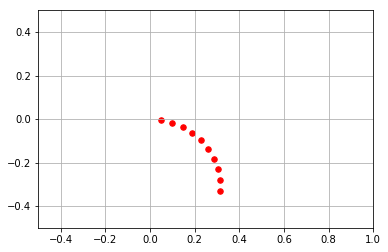

 -- x_train -- 
[[ 0.05082732 -0.00413283 -1.73306181]
 [ 0.10031928 -0.01642275 -1.89532729]
 [ 0.14717562 -0.03654686 -2.05759277]
 [ 0.1901653  -0.06397647 -2.21985825]
 [ 0.2281589  -0.09799092 -2.38212373]
 [ 0.26015822 -0.13769659 -2.54438921]
 [ 0.28532257 -0.1820503  -2.70665469]
 [ 0.30299082 -0.22988678 -2.86892017]
 [ 0.31269878 -0.27994926 -3.03118565]
 [ 0.31419141 -0.33092247 -3.19345113]]


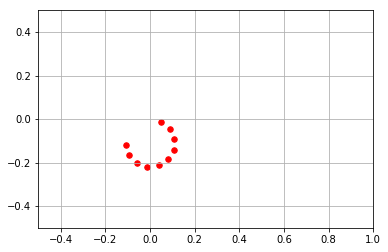

 -- x_train -- 
[[ 0.049236   -0.01164168 -2.03516101]
 [ 0.08804444 -0.04410117 -2.49952569]
 [ 0.10820617 -0.09050394 -2.96389037]
 [ 0.10545119 -0.14102248 -3.42825506]
 [ 0.08036297 -0.18495759 -3.89261974]
 [ 0.03825488 -0.21300437 -4.35698442]
 [-0.01195511 -0.21922286 -4.8213491 ]
 [-0.05963315 -0.20229607 -5.28571379]
 [-0.09468165 -0.16580887 -5.75007847]
 [-0.10967776 -0.1174888  -6.21444315]]


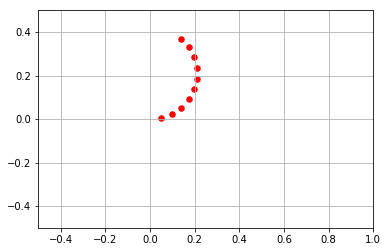

 -- x_train -- 
[[ 0.0505552   0.00614102 -1.32903756]
 [ 0.09816995  0.0242069  -1.08727879]
 [ 0.14007483  0.05314688 -0.84552002]
 [ 0.17383251  0.09127771 -0.60376124]
 [ 0.19747953  0.13638158 -0.36200247]
 [ 0.20964052  0.1858351  -0.1202437 ]
 [ 0.20960814  0.23676191  0.12151507]
 [ 0.19738429  0.28619993  0.36327384]
 [ 0.17367994  0.3312737   0.60503261]
 [ 0.13987382  0.36936158  0.84679138]]


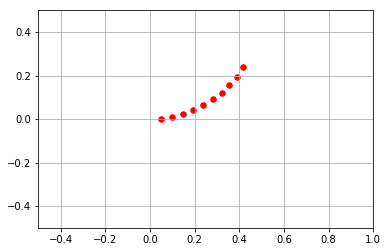

 -- x_train -- 
[[ 0.04996021  0.00259548 -1.46698793]
 [ 0.09938252  0.01035396 -1.36317953]
 [ 0.14773482  0.02319192 -1.25937112]
 [ 0.19449654  0.04097113 -1.15556272]
 [ 0.23916421  0.06350018 -1.05175432]
 [ 0.28125692  0.09053651 -0.94794592]
 [ 0.32032147  0.12178902 -0.84413752]
 [ 0.35593727  0.15692125 -0.74032912]
 [ 0.38772088  0.19555493 -0.63652072]
 [ 0.41533008  0.23727412 -0.53271232]]


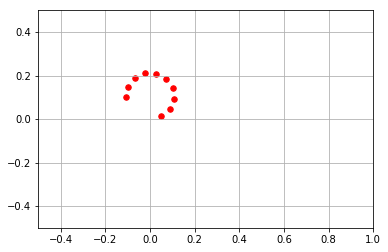

 -- x_train -- 
[[ 0.0491283   0.01197302 -1.09269798]
 [ 0.08723923  0.04520704 -0.61459963]
 [ 0.10578615  0.09224909 -0.13650127]
 [ 0.10060977  0.14254967  0.34159708]
 [ 0.07287094  0.18482851  0.81969543]
 [ 0.02879029  0.20960428  1.29779378]
 [-0.02174679  0.21132085  1.77589213]
 [-0.067407    0.18959325  2.25399048]
 [-0.09795071  0.14929406  2.73208883]
 [-0.10652828  0.09946065  3.21018718]]


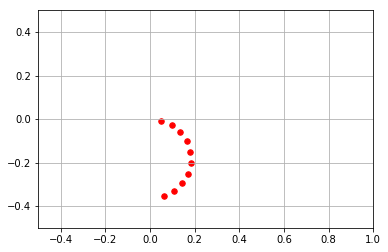

 -- x_train -- 
[[ 0.05039125 -0.0070759  -1.84981041]
 [ 0.09688498 -0.0277563  -2.1288245 ]
 [ 0.13588512 -0.06044169 -2.40783858]
 [ 0.16437522 -0.102604   -2.68685267]
 [ 0.18015169 -0.15098219 -2.96586676]
 [ 0.18199431 -0.20183444 -3.24488084]
 [ 0.16976055 -0.25122757 -3.52389493]
 [ 0.14439664 -0.29534126 -3.80290901]
 [ 0.10786435 -0.33076354 -4.0819231 ]
 [ 0.06298928 -0.35475467 -4.36093718]]


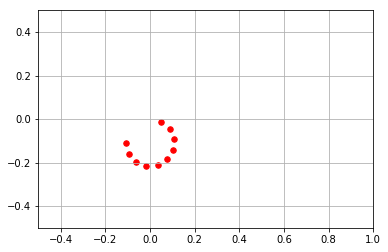

 -- x_train -- 
[[ 0.04918826 -0.01178983 -2.04129605]
 [ 0.08768711 -0.0445972  -2.51179578]
 [ 0.10713013 -0.09129254 -2.9822955 ]
 [ 0.10329202 -0.14172818 -3.45279523]
 [ 0.07700687 -0.18494364 -3.92329495]
 [ 0.03398688 -0.21154751 -4.39379468]
 [-0.01641901 -0.21575831 -4.8642944 ]
 [-0.06325679 -0.19666098 -5.33479413]
 [-0.09634783 -0.15840569 -5.80529385]
 [-0.10850093 -0.10930592 -6.27579357]]


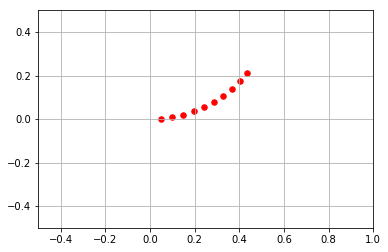

 -- x_train -- 
[[ 0.04998237  0.00225311 -1.4807013 ]
 [ 0.0995593   0.00899415 -1.39060628]
 [ 0.14832864  0.02016844 -1.30051125]
 [ 0.19589479  0.03568535 -1.21041622]
 [ 0.24187192  0.055419   -1.1203212 ]
 [ 0.28588708  0.07920932 -1.03022617]
 [ 0.32758323  0.10686334 -0.94013115]
 [ 0.36662214  0.13815674 -0.85003612]
 [ 0.40268716  0.17283567 -0.75994109]
 [ 0.43548572  0.21061884 -0.66984607]]


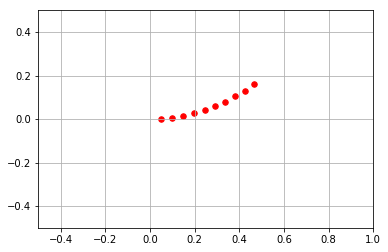

 -- x_train -- 
[[ 0.050013    0.00166741 -1.50414188]
 [ 0.09980388  0.00666224 -1.43748742]
 [ 0.14915151  0.01496231 -1.37083297]
 [ 0.19783674  0.02653075 -1.30417852]
 [ 0.24564334  0.04131618 -1.23752407]
 [ 0.292359    0.05925295 -1.17086962]
 [ 0.33777624  0.08026139 -1.10421517]
 [ 0.38169336  0.10424819 -1.03756072]
 [ 0.42391531  0.13110684 -0.97090626]
 [ 0.46425458  0.16071804 -0.90425181]]


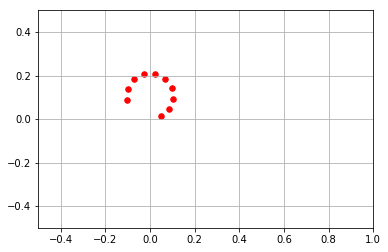

 -- x_train -- 
[[ 0.04906503  0.01216298 -1.08480319]
 [ 0.08676773  0.04583525 -0.59881005]
 [ 0.10437702  0.09321909 -0.11281691]
 [ 0.09781499  0.14334149  0.37317624]
 [ 0.06860126  0.18459526  0.85916938]
 [ 0.02350106  0.20742697  1.34516252]
 [-0.02704145  0.20654933  1.83115566]
 [-0.07132178  0.18216557  2.3171488 ]
 [-0.09908563  0.13992241  2.80314194]
 [-0.10390352  0.0896024   3.28913508]]


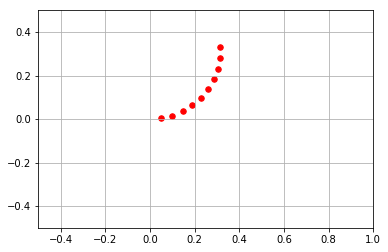

 -- x_train -- 
[[ 0.05082652  0.00414018 -1.40824109]
 [ 0.10031294  0.01645156 -1.24568585]
 [ 0.1471545   0.03660953 -1.08313062]
 [ 0.19011618  0.06408261 -0.92057538]
 [ 0.22806524  0.09814644 -0.75802014]
 [ 0.26000112  0.1379029  -0.59546491]
 [ 0.28508179  0.18230375 -0.43290967]
 [ 0.30264597  0.23017833 -0.27035443]
 [ 0.31223057  0.28026437 -0.1077992 ]
 [ 0.31358288  0.3312413   0.05475604]]


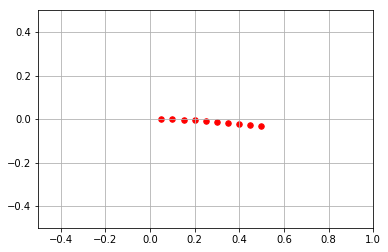

 -- x_train -- 
[[ 5.00485352e-02 -3.37233557e-04 -1.58427238e+00]
 [ 1.00087981e-01 -1.34887299e-03 -1.59774844e+00]
 [ 1.50109252e-01 -3.03473457e-03 -1.61122450e+00]
 [ 2.00103262e-01 -5.39451216e-03 -1.62470055e+00]
 [ 2.50060933e-01 -8.42777722e-03 -1.63817661e+00]
 [ 2.99973193e-01 -1.21339789e-02 -1.65165267e+00]
 [ 3.49830977e-01 -1.65124441e-02 -1.66512873e+00]
 [ 3.99625231e-01 -2.15623778e-02 -1.67860478e+00]
 [ 4.49346913e-01 -2.72828628e-02 -1.69208084e+00]
 [ 4.98986993e-01 -3.36728604e-02 -1.70555690e+00]]


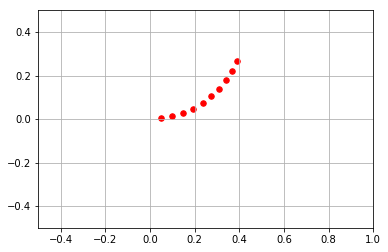

 -- x_train -- 
[[ 0.04992882  0.00301429 -1.4501994 ]
 [ 0.09913237  0.01201336 -1.32960247]
 [ 0.14689593  0.02686649 -1.20900554]
 [ 0.19252568  0.04735793 -1.08840861]
 [ 0.2353588   0.07319003 -0.96781168]
 [ 0.27477309  0.10398753 -0.84721475]
 [ 0.31019603  0.13930308 -0.72661782]
 [ 0.34111307  0.17862369 -0.60602088]
 [ 0.36707509  0.22137818 -0.48542395]
 [ 0.38770498  0.2669455  -0.36482702]]


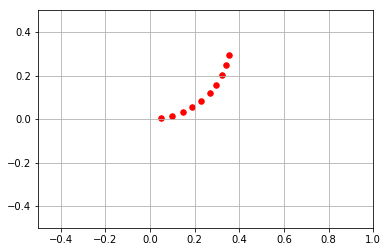

 -- x_train -- 
[[ 0.0498883   0.00348075 -1.43148047]
 [ 0.0988099   0.01385554 -1.29216461]
 [ 0.1458168   0.03092335 -1.15284875]
 [ 0.18999812  0.05435343 -1.01353289]
 [ 0.23049776  0.08369177 -0.87421704]
 [ 0.26653091  0.11836986 -0.73490118]
 [ 0.29739936  0.15771573 -0.59558532]
 [ 0.32250493  0.20096696 -0.45626946]
 [ 0.34136116  0.24728544 -0.3169536 ]
 [ 0.35360264  0.29577363 -0.17763774]]


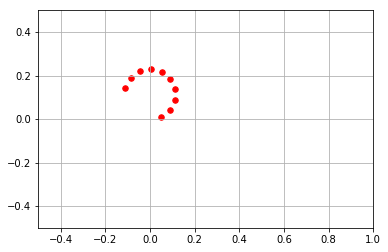

 -- x_train -- 
[[ 0.04938622  0.01116132 -1.12626308]
 [ 0.08917289  0.04247576 -0.68172983]
 [ 0.11162641  0.08785652 -0.23719658]
 [ 0.11238231  0.13848263  0.20733667]
 [ 0.09129367  0.18451352  0.65186992]
 [ 0.05245964  0.21700185  1.09640317]
 [ 0.00342866  0.22963264  1.54093642]
 [-0.04626877  0.21995075  1.98546967]
 [-0.08697262  0.18983812  2.43000292]
 [-0.11077098  0.14514794  2.87453617]]


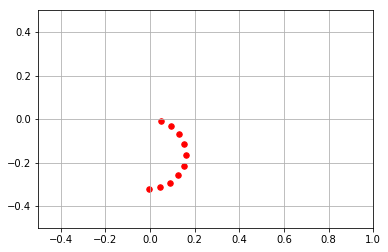

 -- x_train -- 
[[ 0.05019252 -0.00806034 -1.88925433]
 [ 0.09533762 -0.03143081 -2.20771234]
 [ 0.13089544 -0.06776123 -2.52617034]
 [ 0.15329024 -0.11339818 -2.84462835]
 [ 0.16026998 -0.16375234 -3.16308636]
 [ 0.15113276 -0.21376003 -3.48154436]
 [ 0.12679744 -0.25839242 -3.80000237]
 [ 0.0897112  -0.29316121 -4.11846037]
 [ 0.04360348 -0.31457001 -4.43691838]
 [-0.00688906 -0.32046593 -4.75537639]]


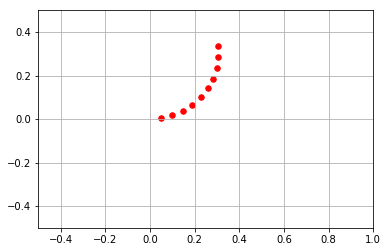

 -- x_train -- 
[[ 0.05081568  0.00423857 -1.40436009]
 [ 0.10022697  0.01683716 -1.23792386]
 [ 0.14686826  0.03744755 -1.07148762]
 [ 0.18945054  0.06550016 -0.90505138]
 [ 0.22679695  0.10021968 -0.73861515]
 [ 0.25787534  0.14064656 -0.57217891]
 [ 0.2818268   0.18566352 -0.40574268]
 [ 0.29798937  0.23402642 -0.23930644]
 [ 0.30591637  0.28439866 -0.0728702 ]
 [ 0.30538872  0.33538808  0.09356603]]


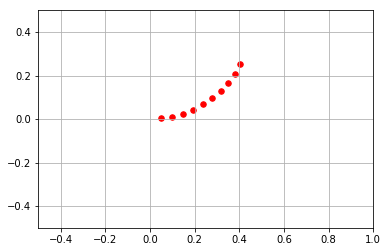

 -- x_train -- 
[[ 0.04994633  0.00278844 -1.45925448]
 [ 0.09927189  0.01111912 -1.34771264]
 [ 0.14736364  0.02488849 -1.2361708 ]
 [ 0.19362385  0.04392542 -1.12462895]
 [ 0.23747756  0.0679933  -1.01308711]
 [ 0.27837974  0.096793   -0.90154527]
 [ 0.31582203  0.12996659 -0.79000342]
 [ 0.34933906  0.16710174 -0.67846158]
 [ 0.37851427  0.20773693 -0.56691973]
 [ 0.40298504  0.25136712 -0.45537789]]


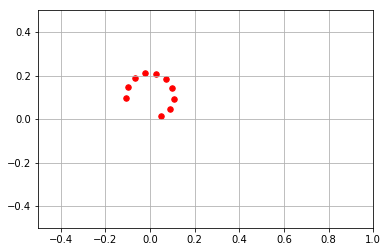

 -- x_train -- 
[[ 0.0491171   0.01200688 -1.09129171]
 [ 0.0871557   0.04531934 -0.61178709]
 [ 0.10553608  0.09242366 -0.13228247]
 [ 0.1001125   0.14269532  0.34722215]
 [ 0.07210826  0.1847954   0.82672677]
 [ 0.02783979  0.20922812  1.30623139]
 [-0.02270802  0.2104826   1.78573601]
 [-0.06813398  0.18827589  2.26524063]
 [-0.09819211  0.14761678  2.74474525]
 [-0.10610274  0.09767605  3.22424987]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.5,1])
    plt.ylim([-.5,.5])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])


In [7]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,dmesg=0):
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_STEP):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)        
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    loss = (1 * e_distance) #  + (1 * e_lim_w) + (1 * e_lim_v)
    if(dmesg):
        print('e_distance: ' + str(e_distance)) # + '\t e_lim_w: '  + str(e_lim_w) + '\t e_lim_v: '  + str(e_lim_v))
    return loss

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 1.0558717
Epoch: 2 , Average loss: 0.5456601
Epoch: 3 , Average loss: 0.38894653
Epoch: 4 , Average loss: 0.32579783
Epoch: 5 , Average loss: 0.29167855
Epoch: 6 , Average loss: 0.27819338
Epoch: 7 , Average loss: 0.25953847
Epoch: 8 , Average loss: 0.24823876
Epoch: 9 , Average loss: 0.23403801
Epoch: 10 , Average loss: 0.23053838
Epoch: 11 , Average loss: 0.21985309
Epoch: 12 , Average loss: 0.21197863
Epoch: 13 , Average loss: 0.21714221
Epoch: 14 , Average loss: 0.19840832
Epoch: 15 , Average loss: 0.19608493
Epoch: 16 , Average loss: 0.19209798
Epoch: 17 , Average loss: 0.18458363
Epoch: 18 , Average loss: 0.18632467
Epoch: 19 , Average loss: 0.17844011
Epoch: 20 , Average loss: 0.18181251
Epoch: 21 , Average loss: 0.17815942
Epoch: 22 , Average loss: 0.17494266
Epoch: 23 , Average loss: 0.16542152
Epoch: 24 , Average loss: 0.16656855
Epoch: 25 , Average loss: 0.16277024
Epoch: 26 , Average loss: 0.16387366
Epoch: 27 , Average loss: 0.16149093
Epoch: 28 , 

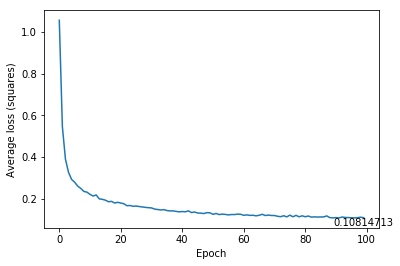

In [9]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [10]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    name_epoch = '{}epoch'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_WAYPOINTS)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 0.04867952  0.00985921 -1.17113633]
 [ 0.0896865   0.03788291 -0.77147633]
 [ 0.1165577   0.07965418 -0.37181633]
 [ 0.12505785  0.12858931  0.02784367]
 [ 0.11384722  0.17697548  0.42750367]
 [ 0.08469275  0.21718639  0.82716367]
 [ 0.04218957  0.24288425  1.22682367]
 [-0.00696324  0.25001875  1.62648367]
 [-0.05501855  0.23746539  2.02614367]
 [-0.09440221  0.20720274  2.42580367]]
 --- output --- 
[[[ 0.04347166  0.          0.65089095]
  [ 0.06197787  0.          0.3670306 ]
  [ 0.05171968  0.          0.36003625]
  [ 0.05136223  0.          0.3861453 ]
  [ 0.05099849  0.          0.41250002]
  [ 0.05013778  0.          0.29334256]
  [ 0.05152612  0.          0.5599159 ]
  [ 0.05116908  0.          0.2675627 ]
  [ 0.05023347  0.          0.4335057 ]
  [ 0.04913635  0.         -0.20575894]]]
[[ 37.293304  21.029305  20.628557  22.124496  23.63451   16.807291
   32.08082   15.330213  24.838049 -11.789119]]
 --- error --- 
e_distance: variable(0.1052845)
loss: vari

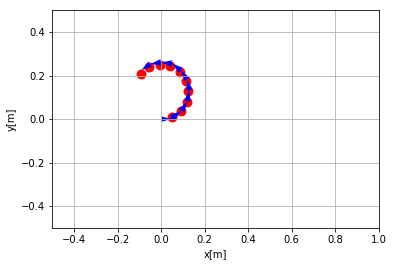

 --- grad --- 
variable([[[ 5.4134474  -1.033389  ]
           [ 8.215611   -1.1004275 ]
           [ 7.624966   -1.0468221 ]
           [ 6.120824   -0.8980512 ]
           [ 4.163413   -0.6900276 ]
           [ 2.0962653  -0.4689495 ]
           [ 0.89833695 -0.2710287 ]
           [-0.79026216 -0.12472177]
           [-0.84631324 -0.03390686]
           [-0.72375536  0.        ]]])


In [11]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, dmesg=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

 --- input --- 
[[ 0.04986718  0.0031533  -1.44449633]
 [ 0.09893994  0.01256299 -1.31819633]
 [ 0.14643655  0.02807914 -1.19189633]
 [ 0.19160034  0.04945459 -1.06559633]
 [ 0.23371185  0.07634882 -0.93929633]
 [ 0.27210021  0.10833338 -0.81299633]
 [ 0.30615388  0.14489875 -0.68669633]
 [ 0.33533037  0.18546241 -0.56039633]
 [ 0.35916488  0.22937818 -0.43409633]
 [ 0.37727771  0.27594645 -0.30779633]]
 --- output --- 
[[[ 0.04794681  0.          0.2154727 ]
  [ 0.05689987  0.          0.1017653 ]
  [ 0.05159214  0.          0.1054515 ]
  [ 0.0507933   0.          0.13090813]
  [ 0.05001882  0.          0.13161181]
  [ 0.04985468  0.          0.09057171]
  [ 0.05056988  0.          0.17111242]
  [ 0.05085038  0.          0.08284101]
  [ 0.04978386  0.          0.13565142]
  [ 0.04951827  0.         -0.11977162]]]
 --- error --- 
loss: variable(0.00369204)
loss: variable(0.00460811)
loss: variable(0.00611473)
loss: variable(0.00728005)
loss: variable(0.00776664)
loss: variable(0.008042

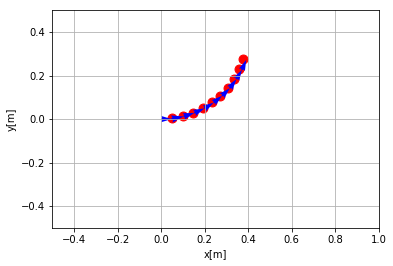

 --- input --- 
[[ 4.83146264e-02 -1.11093939e-02 -2.02281633e+00]
 [ 8.69244518e-02 -4.22060679e-02 -2.47483633e+00]
 [ 1.08074047e-01 -8.70437350e-02 -2.92685633e+00]
 [ 1.07515162e-01 -1.36615999e-01 -3.37887633e+00]
 [ 8.53600577e-02 -1.80965443e-01 -3.83089633e+00]
 [ 4.60589581e-02 -2.11183737e-01 -4.28291633e+00]
 [-2.49385381e-03 -2.21201033e-01 -4.73493633e+00]
 [-5.05457335e-02 -2.09005189e-01 -5.18695633e+00]
 [-8.84446569e-02 -1.77045943e-01 -5.63897633e+00]
 [-1.08577991e-01 -1.31742846e-01 -6.09099633e+00]]
 --- output --- 
[[[ 0.07819466  0.          0.91314983]
  [ 0.00511437  0.          0.98830485]
  [-0.09667766  0.         -0.22300783]
  [-0.05242981  0.         -0.55861336]
  [-0.05376023  0.         -0.83352065]
  [-0.07136704  0.          0.9208566 ]
  [-0.05121779  0.          0.9993271 ]
  [ 0.05466766  0.          0.6191261 ]
  [ 0.0615809   0.         -0.7420106 ]
  [ 0.04893401  0.          0.02709467]]]
 --- error --- 
loss: variable(0.03187844)
loss: varia

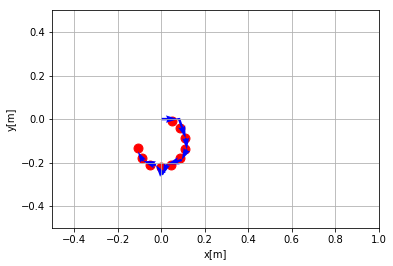

 --- input --- 
[[ 0.04941003  0.00662439 -1.30424633]
 [ 0.09533026  0.02602968 -1.03769633]
 [ 0.13451739  0.05684529 -0.77114633]
 [ 0.16420366  0.09689474 -0.50459633]
 [ 0.18229235  0.14334937 -0.23804633]
 [ 0.18750587  0.19292812  0.02850367]
 [ 0.179476    0.24212928  0.29505367]
 [ 0.15876987  0.28747782  0.56160367]
 [ 0.12684995  0.32577079  0.82815367]
 [ 0.08597071  0.3543036   1.09470367]]
 --- output --- 
[[[ 0.04577329  0.          0.45414925]
  [ 0.05936683  0.          0.23504075]
  [ 0.05165409  0.          0.23315173]
  [ 0.05106965  0.          0.2594624 ]
  [ 0.0504947   0.          0.2739524 ]
  [ 0.0499922   0.          0.19112532]
  [ 0.05103437  0.          0.37669453]
  [ 0.05100518  0.          0.17411464]
  [ 0.05000225  0.          0.28734964]
  [ 0.04933276  0.         -0.16184752]]]
 --- error --- 
loss: variable(0.00755701)
loss: variable(0.00379214)
loss: variable(0.00491577)
loss: variable(0.00624148)
loss: variable(0.00731776)
loss: variable(0.007832

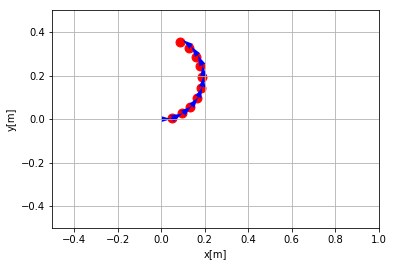

 --- input --- 
[[ 4.99996101e-02  1.70999333e-04 -1.56395633e+00]
 [ 9.99968810e-02  6.83989333e-04 -1.55711633e+00]
 [ 1.49989473e-01  1.53894600e-03 -1.55027633e+00]
 [ 1.99975049e-01  2.73582933e-03 -1.54343633e+00]
 [ 2.49951268e-01  4.27458333e-03 -1.53659633e+00]
 [ 2.99915793e-01  6.15513601e-03 -1.52975633e+00]
 [ 3.49866286e-01  8.37739939e-03 -1.52291633e+00]
 [ 3.99800411e-01  1.09412695e-02 -1.51607633e+00]
 [ 4.49715831e-01  1.38466264e-02 -1.50923633e+00]
 [ 4.99610211e-01  1.70933341e-02 -1.50239633e+00]]
 --- output --- 
[[[ 0.04967397  0.          0.00350533]
  [ 0.05493865  0.         -0.00708517]
  [ 0.0515429   0.          0.00119093]
  [ 0.05057365  0.          0.0252609 ]
  [ 0.04964058  0.          0.01415164]
  [ 0.04974538  0.          0.00920763]
  [ 0.05020069  0.         -0.00473585]
  [ 0.05072733  0.          0.00921429]
  [ 0.04961027  0.          0.0099757 ]
  [ 0.04966572  0.         -0.08601265]]]
 --- error --- 
loss: variable(0.00036781)
loss: varia

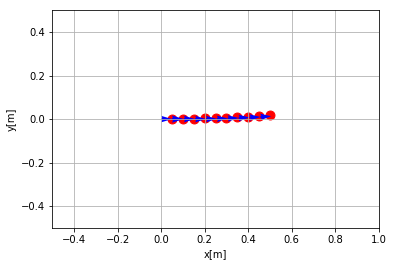

 --- input --- 
[[ 0.0472703   0.01403196 -0.99367633]
 [ 0.07922856  0.05158254 -0.41655633]
 [ 0.08552271  0.10048817  0.16056367]
 [ 0.06411391  0.14490709  0.73768367]
 [ 0.02193702  0.1704509   1.31480367]
 [-0.02734583  0.16884532  1.89192367]
 [-0.06777068  0.14061044  2.46904367]
 [-0.08624291  0.09489224  3.04616367]
 [-0.0767789   0.0465      3.62328367]
 [-0.04244429  0.01110916  4.20040367]]
 --- output --- 
[[[ 0.03945521  0.          0.85579324]
  [ 0.06653099  0.          0.56406003]
  [ 0.05183412  0.          0.5512218 ]
  [ 0.05187263  0.          0.5747051 ]
  [ 0.05187734  0.          0.6127856 ]
  [ 0.05039176  0.          0.4557077 ]
  [ 0.05238396  0.          0.7799793 ]
  [ 0.05145501  0.          0.4184244 ]
  [ 0.05063684  0.          0.6400271 ]
  [ 0.04879368  0.         -0.28032896]]]
 --- error --- 
loss: variable(0.01606149)
loss: variable(0.00407429)
loss: variable(0.00543739)
loss: variable(0.00785378)
loss: variable(0.00980104)
loss: variable(0.009847

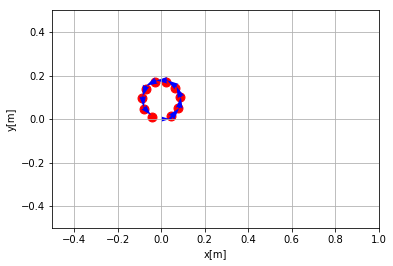

 --- input --- 
[[ 4.99360474e-02 -2.18909894e-03 -1.65841633e+00]
 [ 9.94889677e-02 -8.73960021e-03 -1.74603633e+00]
 [ 1.48278573e-01 -1.96012461e-02 -1.83365633e+00]
 [ 1.95930533e-01 -3.46907021e-02 -1.92127633e+00]
 [ 2.42079245e-01 -5.38921966e-02 -2.00889633e+00]
 [ 2.86370639e-01 -7.70584090e-02 -2.09651633e+00]
 [ 3.28464896e-01 -1.04011600e-01 -2.18413633e+00]
 [ 3.68039054e-01 -1.34544975e-01 -2.27175633e+00]
 [ 4.04789487e-01 -1.68424271e-01 -2.35937633e+00]
 [ 4.38434231e-01 -2.05389555e-01 -2.44699633e+00]]
 --- output --- 
[[[ 0.05108069  0.         -0.1702801 ]
  [ 0.05334076  0.         -0.09574728]
  [ 0.05150279  0.         -0.08386149]
  [ 0.05039472  0.         -0.06132656]
  [ 0.04933247  0.         -0.08196931]
  [ 0.04965635  0.         -0.05721018]
  [ 0.04989994  0.         -0.14826342]
  [ 0.0506271   0.         -0.05087162]
  [ 0.04946887  0.         -0.09281494]
  [ 0.04978582  0.         -0.05836267]]]
 --- error --- 
loss: variable(0.00247029)
loss: varia

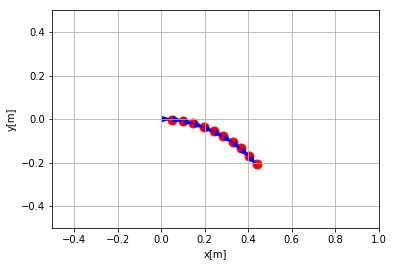

 --- input --- 
[[ 0.04887678 -0.00910582 -1.93917633]
 [ 0.09119547 -0.03520151 -2.30755633]
 [ 0.1212779  -0.07478564 -2.67593633]
 [ 0.13508773 -0.12254696 -3.04431633]
 [ 0.13077202 -0.17207706 -3.41269633]
 [ 0.10890982 -0.21673017 -3.78107633]
 [ 0.07243453 -0.25051491 -4.14945633]
 [ 0.02624025 -0.26889818 -4.51783633]
 [-0.02347485 -0.26941338 -4.88621633]
 [-0.07004018 -0.25199138 -5.25459633]]
 --- output --- 
[[[ 0.05374582  0.         -0.2177151 ]
  [ 0.09772319  0.          0.8988996 ]
  [-0.08678421  0.         -0.54946774]
  [ 0.01673293  0.         -0.47808453]
  [-0.01883948  0.         -0.7674589 ]
  [ 0.09355327  0.          0.66301405]
  [-0.02797773  0.          0.8951021 ]
  [-0.00561724  0.          0.8610591 ]
  [-0.00444173  0.          0.7326181 ]
  [ 0.00212556  0.          0.06178885]]]
 --- error --- 
loss: variable(0.01032587)
loss: variable(0.0596553)
loss: variable(0.03954406)
loss: variable(0.0612422)
loss: variable(0.116287)
loss: variable(0.06688402)


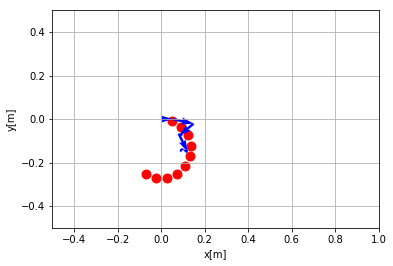

 --- input --- 
[[ 0.04856026  0.01028605 -1.15332633]
 [ 0.08877958  0.03937742 -0.73585633]
 [ 0.11374971  0.08227724 -0.31838633]
 [ 0.11918165  0.13161684  0.09908367]
 [ 0.10414239  0.17892141  0.51655367]
 [ 0.07121514  0.2160657   0.93402367]
 [ 0.02605565  0.23666963  1.35149367]
 [-0.02357928  0.23719417  1.76896367]
 [-0.06916413  0.21754923  2.18643367]
 [-0.10286902  0.18110911  2.60390367]]
 --- output --- 
[[[ 0.04321802  0.          0.66873926]
  [ 0.06226552  0.          0.3808178 ]
  [ 0.05172691  0.          0.37333146]
  [ 0.05139447  0.          0.39935282]
  [ 0.051054    0.          0.42679662]
  [ 0.05015382  0.          0.30425188]
  [ 0.05158031  0.          0.5775449 ]
  [ 0.05118715  0.          0.27759224]
  [ 0.05025895  0.          0.44846368]
  [ 0.04911471  0.         -0.21055053]]]
 --- error --- 
loss: variable(0.01159061)
loss: variable(0.00338174)
loss: variable(0.00424838)
loss: variable(0.00677392)
loss: variable(0.00982387)
loss: variable(0.012069

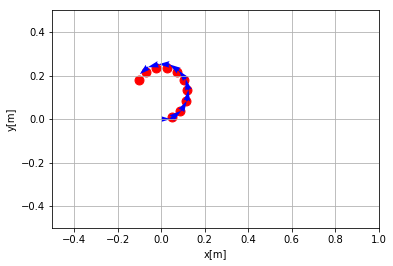

 --- input --- 
[[ 0.04995801  0.001774   -1.49980633]
 [ 0.09966437  0.00708708 -1.42881633]
 [ 0.14886866  0.01591247 -1.35782633]
 [ 0.19732304  0.02820571 -1.28683633]
 [ 0.24478341  0.04390487 -1.21584633]
 [ 0.29101069  0.06293087 -1.14485633]
 [ 0.33577201  0.08518787 -1.07386633]
 [ 0.3788419   0.11056375 -1.00287633]
 [ 0.42000338  0.13893068 -0.93188633]
 [ 0.45904911  0.17014576 -0.86089633]]
 --- output --- 
[[[ 0.04875295  0.          0.11782259]
  [ 0.05598458  0.          0.05110627]
  [ 0.05156916  0.          0.05693898]
  [ 0.05069078  0.          0.08182234]
  [ 0.04984229  0.          0.0770475 ]
  [ 0.04980367  0.          0.05268131]
  [ 0.05039757  0.          0.0897049 ]
  [ 0.05079295  0.          0.04854121]
  [ 0.04970284  0.          0.07729015]
  [ 0.04958709  0.         -0.10404518]]]
 --- error --- 
loss: variable(0.00214459)
loss: variable(0.00471228)
loss: variable(0.00635034)
loss: variable(0.00743928)
loss: variable(0.00763167)
loss: variable(0.007674

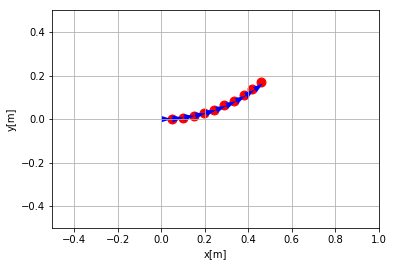

 --- input --- 
[[ 0.04937757  0.00680259 -1.29698633]
 [ 0.09507628  0.02670353 -1.02317633]
 [ 0.13369137  0.05822012 -0.74936633]
 [ 0.16234582  0.09900422 -0.47555633]
 [ 0.17890474  0.14601721 -0.20174633]
 [ 0.18213442  0.19575642  0.07206367]
 [ 0.17179424  0.24451604  0.34587367]
 [ 0.14865458  0.28866325  0.61968367]
 [ 0.11443946  0.32490887  0.89349367]
 [ 0.07169806  0.35055244  1.16730367]]
 --- output --- 
[[[ 0.04565004  0.          0.46626094]
  [ 0.05950668  0.          0.24238738]
  [ 0.05165761  0.          0.24019955]
  [ 0.05108532  0.          0.26652774]
  [ 0.05052168  0.          0.2817356 ]
  [ 0.04999999  0.          0.1967286 ]
  [ 0.05106071  0.          0.38751137]
  [ 0.05101396  0.          0.17921634]
  [ 0.05001464  0.          0.2956085 ]
  [ 0.04932224  0.         -0.16421719]]]
 --- error --- 
loss: variable(0.00775691)
loss: variable(0.00372873)
loss: variable(0.00483808)
loss: variable(0.00616042)
loss: variable(0.00722965)
loss: variable(0.007689

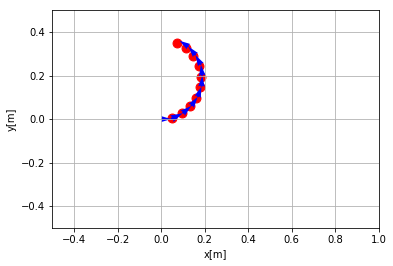

In [12]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    x_test = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
    fig.savefig(dirname + '/test' + str(i) + '.png')